# Patch Visualization

Visualize the patches being created for the vision transformer of the lidar encoder

In [1]:
import torch
from termcolor import cprint
from torch import nn
from dataset import CLIPSet

import pandas as pd
import matplotlib.pyplot as plt

### Create Dataset

In [2]:
dataset = CLIPSet(pickle_file_path='./data/test_final.pkl', include_lidar_file_names=True)

Pickle file exists. Loading from pickle file
Delay frame is : 30


### Extract Sample from Dataset

In [3]:
idx = 392

sample = dataset[idx]
lidar_stack = sample[0][0]
file_names = sample[0][1]
print('lidar stack shape: ', lidar_stack.shape)

lidar stack shape:  (5, 401, 401)


### Visualize the Lidar Stack

index: 392


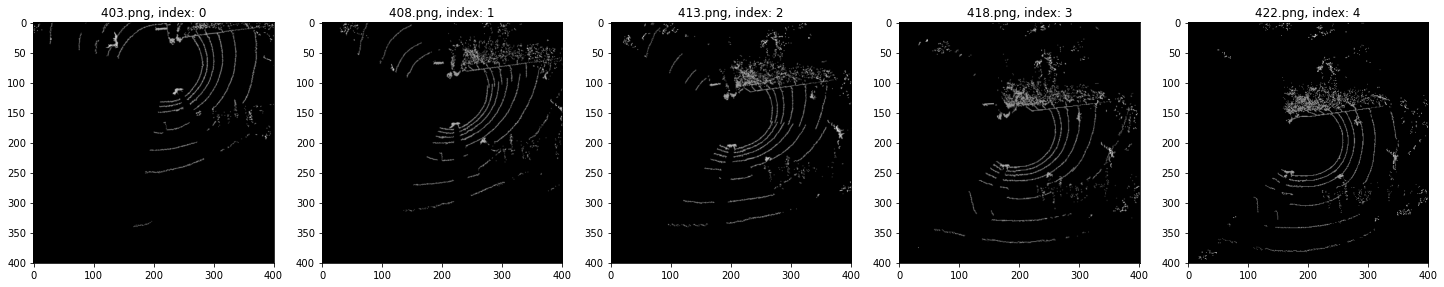

In [4]:
from lidar_helper import visualize_lidar_stack

cprint(f'index: {idx}', color='green', attrs=['bold'])
visualize_lidar_stack(lidar_stack=lidar_stack, file_names=file_names)

### Define Patch Size, Embedding Size

In [5]:
patch_size = 16
input_channels = 5
embedding_dim = 768

# learnable linear projection
# for patch vectors
lin_proj = nn.Linear(in_features=patch_size ** 2 * input_channels,
                     out_features=embedding_dim)

### Convert Lidar Image to Torch Tensor

In [6]:
x = torch.from_numpy(lidar_stack)
# add batch size dim as 1
x = torch.unsqueeze(x, 0) 
print('lidar_stack batch shape: ', x.shape)

lidar_stack batch shape:  torch.Size([1, 5, 401, 401])


### Create Patches

In [7]:
# batch_size, channels, v slices, h slices, patch_size, patch_size
x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size,
                                             patch_size)
# batch_size, channels, num_patches, patch_size, patch_size
x = x.reshape(x.shape[0], x.shape[1], -1, patch_size, patch_size)

x.shape

torch.Size([1, 5, 625, 16, 16])

### Find non-empty patches

In [8]:
current_lidar_img = x[0, 4, :, :, :]
print(current_lidar_img.shape)
for i, img in enumerate(current_lidar_img):
    patch_value = torch.max(img).item()
    if patch_value > 0.0:
        print(f'{i}, {patch_value:.2f}')

torch.Size([625, 16, 16])
7, 0.74
8, 0.78
9, 0.77
10, 0.77
13, 0.76
14, 0.72
15, 0.77
16, 0.78
18, 0.75
34, 0.75
37, 0.73
38, 0.74
39, 0.75
41, 0.76
53, 0.79
67, 0.73
68, 0.75
78, 0.78
79, 0.76
89, 0.69
90, 0.51
91, 0.71
92, 0.73
93, 0.74
113, 0.67
114, 0.68
115, 0.68
118, 0.69
119, 0.54
134, 0.49
138, 0.66
139, 0.65
140, 0.67
141, 0.55
159, 0.49
160, 0.54
161, 0.54
162, 0.54
163, 0.56
164, 0.54
165, 0.56
166, 0.49
167, 0.47
168, 0.53
169, 0.56
184, 0.49
185, 0.54
186, 0.54
187, 0.55
188, 0.54
189, 0.54
190, 0.56
191, 0.53
192, 0.55
193, 0.66
194, 0.69
195, 0.70
197, 0.73
199, 0.78
209, 0.49
210, 0.51
211, 0.53
212, 0.53
213, 0.50
214, 0.51
215, 0.55
216, 0.53
217, 0.53
218, 0.53
219, 0.67
220, 0.69
221, 0.70
222, 0.73
224, 0.78
235, 0.49
236, 0.48
237, 0.47
238, 0.49
239, 0.48
240, 0.47
241, 0.45
242, 0.54
243, 0.45
244, 0.43
246, 0.44
247, 0.73
248, 0.75
249, 0.76
260, 0.50
261, 0.44
265, 0.42
266, 0.42
267, 0.58
268, 0.44
269, 0.43
271, 0.44
272, 0.72
273, 0.73
274, 0.77
290, 0.42
2

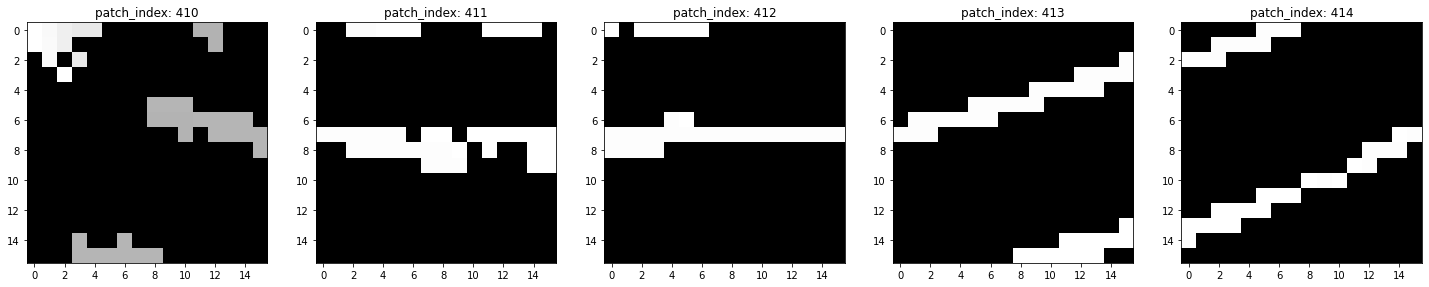

In [9]:
rows, cols = 1, 5
plt.figure(figsize=(25, 25))
start, stop = 410, 415

for i, img in enumerate(current_lidar_img[start:stop]):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'patch_index: {start + i}')
    plt.imshow(img, cmap='gray')
plt.show()

### Pass Batch through Linear Transformation

In [10]:
x = x.movedim(1, -1)  # batch_size, num patches p channel, patch_size ** 2, channels
x = x.flatten(-3)  # 3D patch to 1D patch vector
print(f'flatten patches: {x.shape}')
x = lin_proj.forward(x)  # linear transformation
print(f'embeddings shape: {x.shape}')

flatten patches: torch.Size([1, 625, 1280])
embeddings shape: torch.Size([1, 625, 768])
